In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [ ]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 4356 (delta 213), reused 253 (delta 177), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 29.15 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Get Data

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download.")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi, downloading it...
Unzipping pizza, steak, sushi data...


In [ ]:
# directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir , test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Create Datasets and DataLoaders

## Creating a transform for torchvision.models (manual creation)

In [ ]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
                                        transforms.Resize((224, 224)), # resize image to 224, 224 (height x width)
                                        transforms.ToTensor(), # get images into range [0, 1]
                                        normalize]) # make sure images have the same distribution as ImageNet (where our pretrained models have been trained)


In [ ]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7de090712680>,
 ['pizza', 'steak', 'sushi'])

## Creating a transform for torchvision.models (auto creation)

In [ ]:
# get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7de090710d00>,
 ['pizza', 'steak', 'sushi'])

# Getting a pretrained model

## Which pretrained model should we use?

## Setting up a pretrained model

In [ ]:
# old method of creating pretrained model
model = torchvision.models.efficientnet_b0(pretrained=True)

# new method of creating pretrained models
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)

model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

## Getting a summary of our model with `torchinfo.summary()`

In [ ]:
from torchinfo import summary

summary(model = model,
        input_size = (1,3,224,224),
        col_names = ["input_size", 'output_size','num_params','trainable'],
        col_width =20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Freezing the base model and changing the output layer to suit our needs

In [ ]:
# freeze all of the base layers
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
len(class_names)

3

In [ ]:
# update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,
              out_features = len(class_names))).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
summary(model = model,
        input_size = (1,3,224,224),
        col_names = ["input_size", 'output_size','num_params','trainable'],
        col_width =20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

# Train model

In [ ]:
# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr = 0.001)

In [ ]:
# import train function
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                          train_dataloader=train_dataloader,
                          test_dataloader=test_dataloader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=5,
                          device=device)

end_time = timer()

print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
[INFO] Total training time: 186.514 seconds


# Evalaute model by plotting loss curves

[INFO] Couldn't find helper_functions.py, downloading...


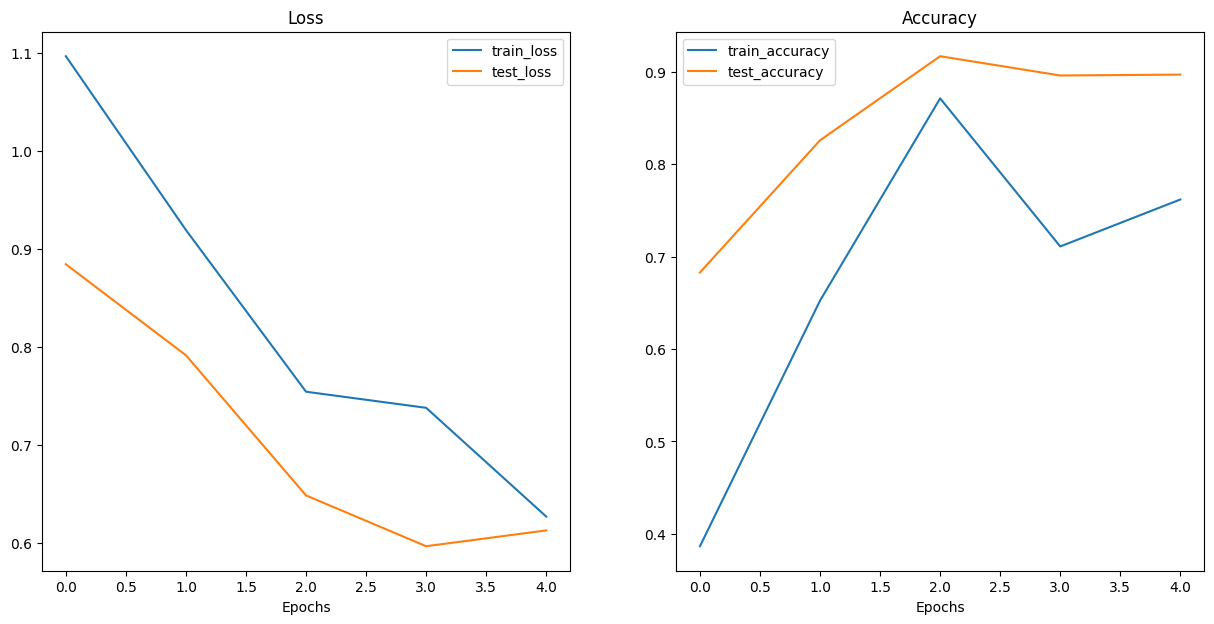

In [ ]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

# Make predictions on images from the test set

In [ ]:
from typing import List, Tuple, Dict
from PIL import Image
import torchvision
from torchvision import transforms


# 1. Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 2. Open the image with PIL
  img = Image.open(image_path)

  # create a transform
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

  ### Predict on image ###
  # Make sure the model is on the target device
  model.to(device)

  # Turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

    # Make a prediction on the transformed image by passing it to the model (also ensure it's on the target device)
    target_image_pred = model(transformed_image.to(device))

  # Convert the model's output logits to pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  # print(target_image_pred_probs.max())

  # Convert the model's pred probs to pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)

In [ ]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

In [ ]:
class_names

['pizza', 'steak', 'sushi']

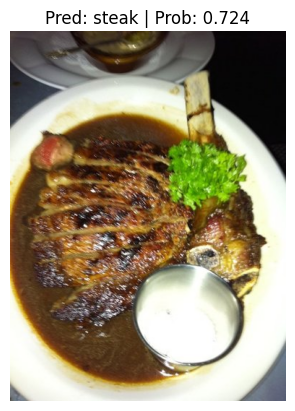

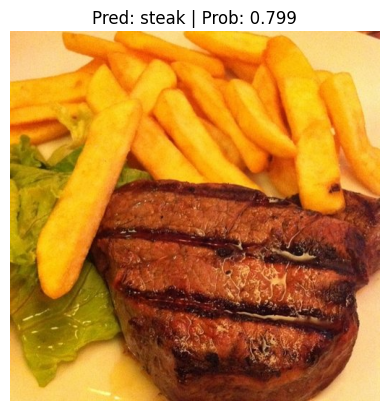

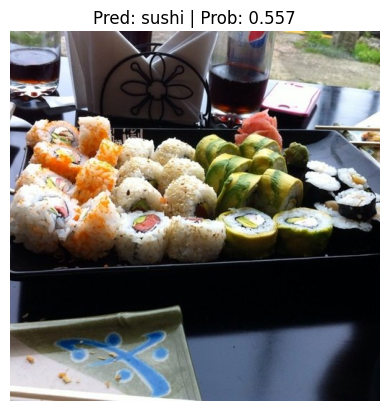

In [ ]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

## Making predictions on a custom image

In [ ]:
# Download the image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # Download image from GitHub with "raw" link
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
    print(f"Download {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

Download data/04-pizza-dad.jpeg...


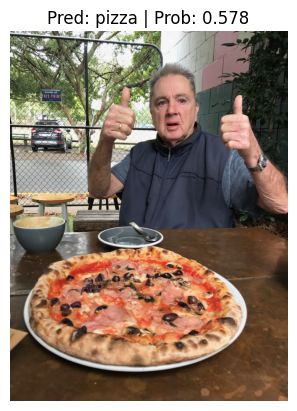

In [ ]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)